# Preprocessing of datasets

Attack traffic datasets (Booters) from https://ieeexplore.ieee.org/document/7140298/

Benign traffic datasets from http://mawi.wide.ad.jp/mawi/

In [ ]:
import pandas as pd
from collections import Counter
import hashlib
import random
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

In [ ]:
# load datasets
df = []
df.append(pd.read_csv('anon-Booter_dns1.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns2.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns3.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns4.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns5.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns6.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns7.pcap.csv'))
df.append(pd.read_csv('wideg_dns_cleared.csv'))
df.append(pd.read_csv('widef_dns_cleared.csv'))

Show first samples of datasets. The 7 *booter* datasets have the same structure, as well as the 2 *wide* datasets.

In [ ]:
df[0].head()

,frame.time_relative,ip.len,ip.src,ip.dst,udp.length,dns.id,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,...,dns.flags.authenticated,dns.flags.checkdisable,dns.flags.rcode,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dns.qry.class
0,0.000000,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
1,0.000085,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
2,0.000172,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
3,0.000259,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
4,0.000347,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001


In [ ]:
df[7].head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,src_AS
0,87.0,210.166.249.129,133.91.254.11,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623,7514
1,286.0,8.8.8.8,150.65.3.6,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932,15169
2,135.0,8.8.8.8,203.178.130.217,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500,15169
3,208.0,8.8.8.8,150.65.3.6,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932,15169
4,232.0,203.178.141.194,157.7.180.137,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506,2500


At first, delete columns that do not exist in both datasets and, if needed, reorder the rest columns of one dataset to match the order of the other. For now, keep the *dst_AS* column of the *wide* datasets, because it will help distribute samples to clients. Also, drop *ip.src* and *ip.dst*, because they are too specific and do not really contribute to distinguishing attack and benign traffic in general case.

In [ ]:
for i in range(7):
    df[i].drop(columns=['ip.src', 'ip.dst', 'frame.time_relative', 'dns.id', 'dns.flags.z', 'dns.flags.rcode', 'dns.qry.class'], inplace=True)
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
1,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
2,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
3,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
4,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0


In [ ]:
for i in range(7, 9):
    df[i].drop(columns=['ip.src', 'ip.dst', 'src_AS'], inplace=True)
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506


Drop samples with missing values.

In [ ]:
for i in range(9):
    df[i].dropna(axis=0, inplace=True)

Add a column for the target, i.e. 0 for benign traffic and 1 for attack traffic.

In [ ]:
for i in range(7):
    df[i] = df[i].assign(target = [1.0 for j in range(len(df[i]))])
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
1,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
2,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
3,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
4,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0


In [ ]:
for i in range(7, 9):
    df[i] = df[i].assign(target = [0.0 for j in range(len(df[i]))])
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506,0.0


Notice that *dns.qry.name* and *dns.qry.type* are nominal categorical features. Transform the former to a numerical value via hashing. As far as the latter is concerned, one-hot encoding could be used, but that would add 255 columns to the dataset. A more efficient solution would be binary encoding. However, when trying to fit such an encoder in the concatenation of *dns.qry.type* columns of all datasets, memory issues occur (RAM gets exhausted). Another choice is to leave the feature as it is.

**Note:** Representing the values of a nominal feature as numbers is theoretically wrong in machine learning, because some order among these values is supposed, without such existing. However, due to the fact that some names or types appear in high frequence in one kind of traffic (e.g. DNS root zone name and DNS ANY type query in attack traffic), and after testing in practice, it was found that this representation tends to improve the results of the classifier, compared to dropping the aforementioned columns.

In [ ]:
for i in range(9):
    df[i]['dns.qry.name'] = df[i]['dns.qry.name'].apply(lambda a: int(hashlib.sha256(a.encode('utf-8')).hexdigest(), 16) % 10**8)
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,70141173,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,60770939,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,91479927,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,34701380,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,28816654,1.0,7506,0.0


Convert to float numbers.

In [ ]:
for i in range(7):
    df[i] = df[i].astype('float32')
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
1,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
2,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
3,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
4,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0


In [ ]:
for i in range(7, 9):
    df[i].iloc[:, :-2] = df[i].iloc[:, :-2].astype('float32')
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,70141176.0,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,60770940.0,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,91479928.0,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,34701380.0,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,28816654.0,1.0,7506,0.0


Make a general benign traffic test set with samples from both *wide* datasets to compare clients' performance in recognizing benign traffic before and after federated learning.

In [ ]:
# shuffle datasets
for i in range(9):
    df[i] = df[i].sample(frac=1)

# make test set
general_benign_test = pd.concat([df[7].iloc[:150000, :], df[8].iloc[:150000, :]])
# remove selected samples to avoid selecting any of them for train set
df[7] = df[7].iloc[150000:, :]
df[8] = df[8].iloc[150000:, :]
# remove dst_AS column
general_benign_test.drop(columns=['dst_AS'], inplace=True)

# shuffle test set
general_benign_test = general_benign_test.sample(frac=1).reset_index(drop=True)
general_benign_test

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,121.0,101.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,70249224.0,12.0,0.0
1,126.0,106.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,64076216.0,1.0,0.0
2,197.0,177.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,48069392.0,1.0,0.0
3,581.0,561.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,65501532.0,43.0,0.0
4,124.0,104.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,84075200.0,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,545.0,525.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,1.0,19663036.0,1.0,0.0
299996,154.0,134.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,99791072.0,28.0,0.0
299997,141.0,121.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,18514702.0,1.0,0.0
299998,518.0,498.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,14.0,2202134.0,1.0,0.0


Use the *dst_AS* feature of the *wide* datasets to split the data to clients. Each different destination AS number will represent a distinct federated client in this project. This is realistic because every packet will be received by its destination AS, which could really be a federated learning client trying to classify its receiving packets as benign or attack traffic.

Plan is to do training with 7, 14 and 21 clients. So, make 21 clients using the most frequent destination AS numbers in both *wide* datasets. In each case, about half of the clients will come from the *wideg* dataset and half from the *widef* dataset.

In [ ]:
# not all values of dst_AS columns are of the same type 
for i in range(7, 9):
    df[i].iloc[:, -2] = df[i].iloc[:, -2].astype('str')

In [ ]:
# show the most frequent AS numbers of wideg dataset
gDstAS = Counter(df[7]['dst_AS'])
gDstAS = sorted(gDstAS.items(), key=lambda x: x[1], reverse=True)
gDstAS[:20]

[('2500', 1086304),
 ('38635', 587536),
 ('12389', 318508),
 ('17932', 294641),
 ('15169', 290179),
 ('2907', 289501),
 ('9506', 135316),
 ('8359', 131812),
 ('35473', 117001),
 ('13174', 109018),
 ('4713', 64740),
 ('Unknown', 62031),
 ('2516', 52262),
 ('5384', 45644),
 ('16509', 45373),
 ('35807', 41549),
 ('3758', 40845),
 ('4538', 35989),
 ('133037', 34132),
 ('47764', 34088)]

In [ ]:
# show the most frequent AS numbers of widef dataset
fDstAS = Counter(df[8]['dst_AS'])
fDstAS = sorted(fDstAS.items(), key=lambda x: x[1], reverse=True)
fDstAS[:20]

[('2500', 2616292),
 ('63783', 288282),
 ('16509', 134427),
 ('4134', 62984),
 ('14618', 55669),
 ('63949', 53046),
 ('13335', 50731),
 ('3356', 42588),
 ('8075', 42194),
 ('17676', 37450),
 ('4766', 30958),
 ('36692', 28429),
 ('3786', 23351),
 ('13238', 21252),
 ('7922', 17577),
 ('42', 17422),
 ('9318', 16227),
 ('4837', 15484),
 ('202425', 14156),
 ('6939', 13458)]

In [ ]:
# see if some of the most frequent AS numbers have packets in both datasets
totalDstAS = Counter(pd.concat([df[7]['dst_AS'], df[8]['dst_AS']]))
totalDstAS = sorted(totalDstAS.items(), key=lambda x: x[1], reverse=True)
totalDstAS[:20]

[('2500', 3702596),
 ('38635', 587536),
 ('12389', 322305),
 ('17932', 294641),
 ('15169', 290179),
 ('2907', 289510),
 ('63783', 288282),
 ('16509', 179800),
 ('9506', 135318),
 ('8359', 131903),
 ('35473', 117084),
 ('13174', 109028),
 ('Unknown', 70760),
 ('13335', 65195),
 ('4713', 64740),
 ('4134', 63013),
 ('14618', 55712),
 ('63949', 54962),
 ('2516', 52263),
 ('5384', 45681)]

In [ ]:
# take some of the most frequent AS numbers of wideg and widef datasets as clients,
# but try to have about the same number of packets from the two datasets,
# and assign benign traffic to clients' datasets
# each client takes all packets headed at it (i.e. packets from both datasets)

clients_datasets = []

# leave out AS's with too many packets for time efficiency
gDstAS = gDstAS[10:]
fDstAS = fDstAS[3:]

# avoid choosing packets with unknown AS destination
for l in [gDstAS, fDstAS]:
    for t in l:
        if t[0] == 'Unknown' or t[0] == '16509':
            l.remove((t[0], t[1]))

# avoid choosing same AS twice
chosen_ASs = []

for i in range(21):
    if i % 2 == 0:
        AS_tuple = gDstAS[i//2]
        while AS_tuple[0] in chosen_ASs:
            gDstAS.remove((AS_tuple[0], AS_tuple[1]))
            AS_tuple = gDstAS[i//2]
        clients_datasets.append(pd.concat([df[7][df[7]['dst_AS'] == AS_tuple[0]], df[8][df[8]['dst_AS'] == AS_tuple[0]]]))
        chosen_ASs.append(AS_tuple[0])        
    else:
        AS_tuple = fDstAS[i//2]
        while AS_tuple[0] in chosen_ASs:
            fDstAS.remove((AS_tuple[0], AS_tuple[1]))
            AS_tuple = fDstAS[i//2]
        clients_datasets.append(pd.concat([df[7][df[7]['dst_AS'] == AS_tuple[0]], df[8][df[8]['dst_AS'] == AS_tuple[0]]]))
        chosen_ASs.append(AS_tuple[0])

Check the results of the splitting. Shuffle clients to avoid having most of the packets in the first 7 clients. Also, in all cases have about equally much traffic from both *wide* datasets.

In [ ]:
random.Random(8).shuffle(clients_datasets)

for i in range(21):
    print('Client ' + str(i+1) + ':')
    print('\tNumber of packets: ' + str(len(clients_datasets[i])) + '\tAS number: ' + clients_datasets[i].iloc[0, -2])

for n in [7, 14, 21]:
    totalg = 0
    totalf = 0
    for i in range(len(clients_datasets[:n])):
        for j, k in gDstAS:
            if j == clients_datasets[i].iloc[0, -2]:
                totalg += k
        for j, k in fDstAS:
            if j == clients_datasets[i].iloc[0, -2]:
                totalf += k
    print('\n' + str(n) + ' clients: ')
    print('\tTotal packets from wideg dataset: ' + str(totalg))
    print('\tTotal packets from widef dataset: ' + str(totalf))

Client 1:
	Number of packets: 42176	AS number: 3758
Client 2:
	Number of packets: 31121	AS number: 9231
Client 3:
	Number of packets: 37527	AS number: 17676
Client 4:
	Number of packets: 23352	AS number: 3786
Client 5:
	Number of packets: 41600	AS number: 35807
Client 6:
	Number of packets: 54962	AS number: 63949
Client 7:
	Number of packets: 63013	AS number: 4134
Client 8:
	Number of packets: 65195	AS number: 13335
Client 9:
	Number of packets: 28998	AS number: 25513
Client 10:
	Number of packets: 45681	AS number: 5384
Client 11:
	Number of packets: 64740	AS number: 4713
Client 12:
	Number of packets: 30967	AS number: 4766
Client 13:
	Number of packets: 34132	AS number: 133037
Client 14:
	Number of packets: 55712	AS number: 14618
Client 15:
	Number of packets: 32702	AS number: 2497
Client 16:
	Number of packets: 42590	AS number: 3356
Client 17:
	Number of packets: 44276	AS number: 8075
Client 18:
	Number of packets: 36010	AS number: 4538
Client 19:
	Number of packets: 34165	AS number:

Drop the *dst_AS* column.

In [ ]:
for i in range(21):
    clients_datasets[i].drop(columns=['dst_AS'], inplace=True)
clients_datasets[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
828478,444.0,424.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,10.0,1.0,88441832.0,12.0,0.0
4444115,363.0,343.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,44338272.0,12.0,0.0
2555593,818.0,798.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,53164032.0,12.0,0.0
4037556,697.0,677.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,1.0,46737136.0,1.0,0.0
643425,359.0,339.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,50967416.0,12.0,0.0


Distribute attack traffic to clients. Each *booter* dataset is given to 3 clients. Clients' datasets need to be balanced.

In [ ]:
for i in range(21):
    clients_datasets[i] = pd.concat([clients_datasets[i], df[i%7].iloc[:len(clients_datasets[i]), :]], ignore_index=True)
    # remove used samples from booter datasets
    df[i%7] = df[i%7].iloc[len(clients_datasets[i]):, :]
    # shuffle client dataset
    clients_datasets[i] = clients_datasets[i].sample(frac=1)

In [ ]:
clients_datasets[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
35582,559.0,539.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,69253784.0,43.0,0.0
38508,349.0,329.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,49125748.0,12.0,0.0
56810,896.0,876.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,13.0,13.0,23.0,61960000.0,255.0,1.0
42347,896.0,876.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,13.0,13.0,23.0,61960000.0,255.0,1.0
46397,837.0,817.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,18.0,61960000.0,255.0,1.0


Clients' performance in recognizing all *booter* attacks will be tested before and after federated learning process. So, keep some samples of each *booter* dataset.

In [ ]:
booters_tests = [df[i].iloc[:50000, :] for i in range(7)]

Perform a feature selection technique (random forest) to further reduce the feature set for efficient training. Each client runs random forest privately on its own data multiple times and calculates the average importance score for each feature.

Client 1:
	Feature: ip.len, Score: 0.04767
	Feature: udp.length, Score: 0.05776
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00173
	Feature: dns.flags.truncated, Score: 0.00003
	Feature: dns.flags.recdesired, Score: 0.22040
	Feature: dns.flags.recavail, Score: 0.11107
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00100
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.06643
	Feature: dns.count.auth_rr, Score: 0.13979
	Feature: dns.count.add_rr, Score: 0.04632
	Feature: dns.qry.name, Score: 0.01173
	Feature: dns.qry.type, Score: 0.29607



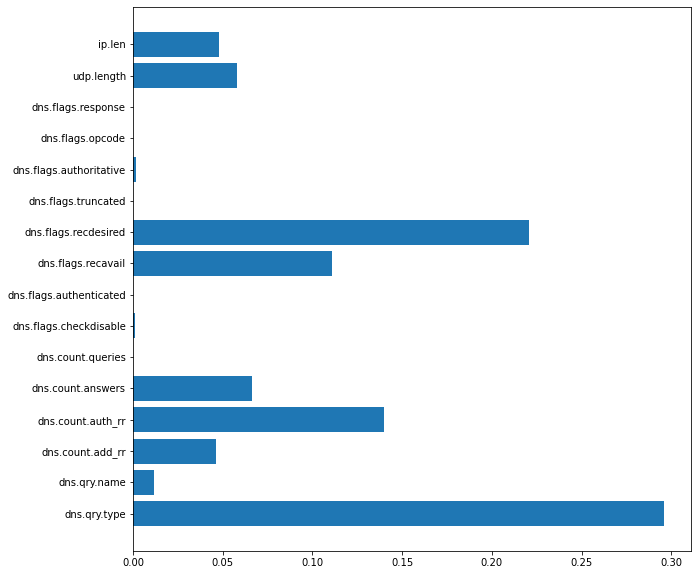

Client 2:
	Feature: ip.len, Score: 0.01290
	Feature: udp.length, Score: 0.01291
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.13775
	Feature: dns.flags.truncated, Score: 0.00010
	Feature: dns.flags.recdesired, Score: 0.24239
	Feature: dns.flags.recavail, Score: 0.02488
	Feature: dns.flags.authenticated, Score: 0.00006
	Feature: dns.flags.checkdisable, Score: 0.13554
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.05229
	Feature: dns.count.auth_rr, Score: 0.08744
	Feature: dns.count.add_rr, Score: 0.00390
	Feature: dns.qry.name, Score: 0.03820
	Feature: dns.qry.type, Score: 0.25164



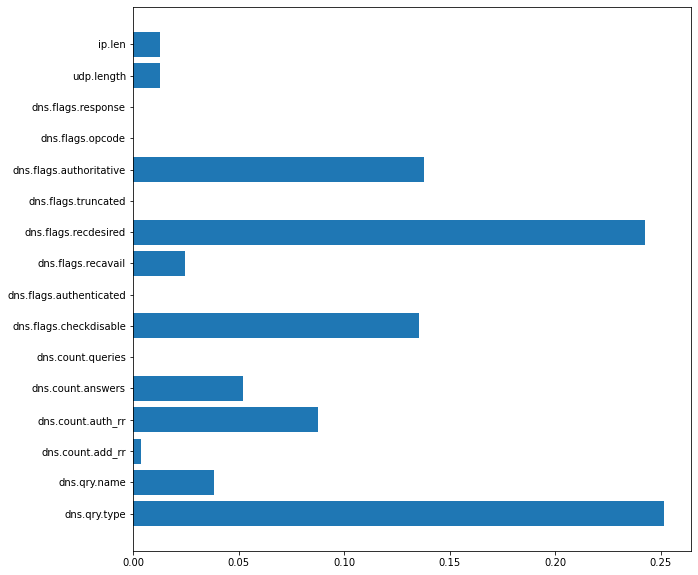

Client 3:
	Feature: ip.len, Score: 0.03100
	Feature: udp.length, Score: 0.02811
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.09319
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.22126
	Feature: dns.flags.recavail, Score: 0.17140
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00229
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.06073
	Feature: dns.count.auth_rr, Score: 0.06072
	Feature: dns.count.add_rr, Score: 0.01046
	Feature: dns.qry.name, Score: 0.00643
	Feature: dns.qry.type, Score: 0.31443



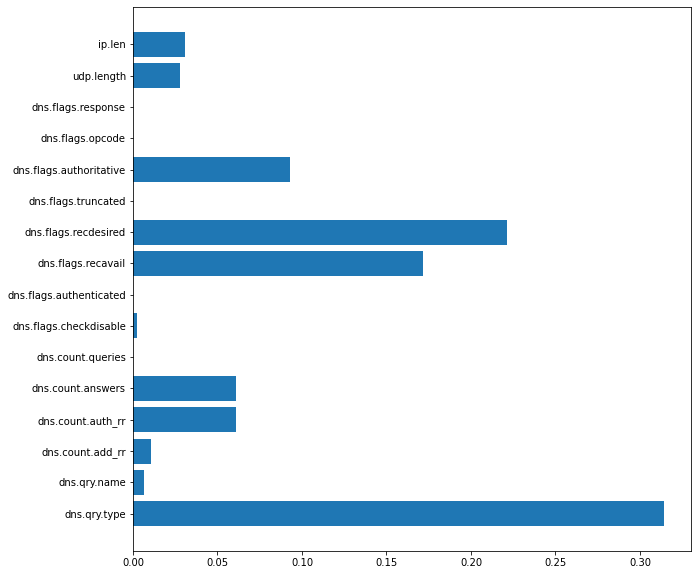

Client 4:
	Feature: ip.len, Score: 0.05654
	Feature: udp.length, Score: 0.08643
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.04069
	Feature: dns.flags.truncated, Score: 0.00015
	Feature: dns.flags.recdesired, Score: 0.30662
	Feature: dns.flags.recavail, Score: 0.13906
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00646
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.13054
	Feature: dns.count.auth_rr, Score: 0.00786
	Feature: dns.count.add_rr, Score: 0.00204
	Feature: dns.qry.name, Score: 0.20855
	Feature: dns.qry.type, Score: 0.01507



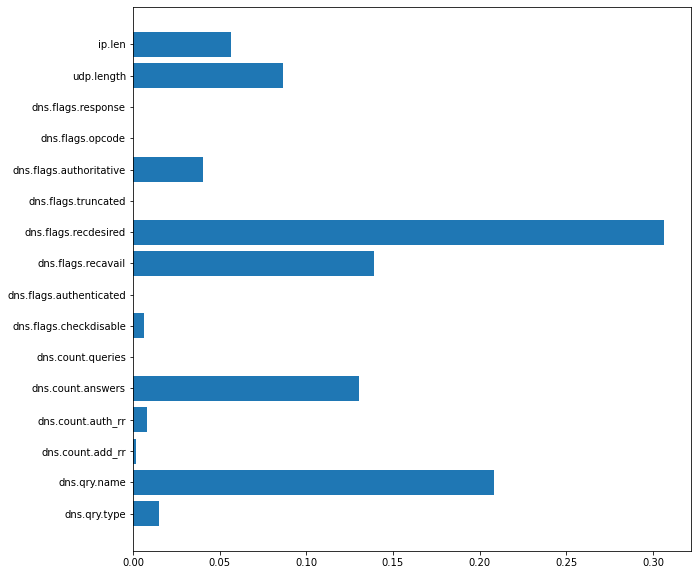

Client 5:
	Feature: ip.len, Score: 0.04207
	Feature: udp.length, Score: 0.03965
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00738
	Feature: dns.flags.truncated, Score: 0.00852
	Feature: dns.flags.recdesired, Score: 0.26317
	Feature: dns.flags.recavail, Score: 0.11454
	Feature: dns.flags.authenticated, Score: 0.00299
	Feature: dns.flags.checkdisable, Score: 0.00008
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.01658
	Feature: dns.count.auth_rr, Score: 0.05920
	Feature: dns.count.add_rr, Score: 0.00519
	Feature: dns.qry.name, Score: 0.26476
	Feature: dns.qry.type, Score: 0.17587



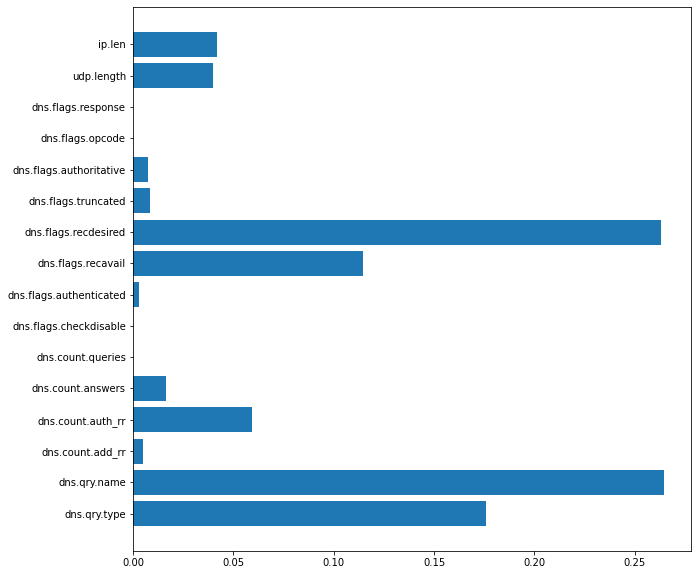

Client 6:
	Feature: ip.len, Score: 0.08354
	Feature: udp.length, Score: 0.09116
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01390
	Feature: dns.flags.truncated, Score: 0.00035
	Feature: dns.flags.recdesired, Score: 0.25656
	Feature: dns.flags.recavail, Score: 0.18935
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.03728
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.06135
	Feature: dns.count.auth_rr, Score: 0.00527
	Feature: dns.count.add_rr, Score: 0.00195
	Feature: dns.qry.name, Score: 0.00333
	Feature: dns.qry.type, Score: 0.25597



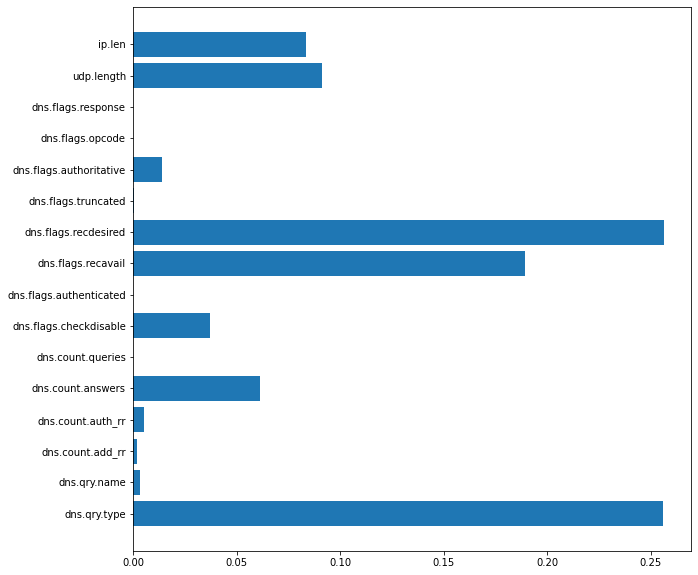

Client 7:
	Feature: ip.len, Score: 0.05333
	Feature: udp.length, Score: 0.07745
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01559
	Feature: dns.flags.truncated, Score: 0.00001
	Feature: dns.flags.recdesired, Score: 0.24201
	Feature: dns.flags.recavail, Score: 0.16008
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.02811
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.11024
	Feature: dns.count.auth_rr, Score: 0.00412
	Feature: dns.count.add_rr, Score: 0.00294
	Feature: dns.qry.name, Score: 0.02688
	Feature: dns.qry.type, Score: 0.27925



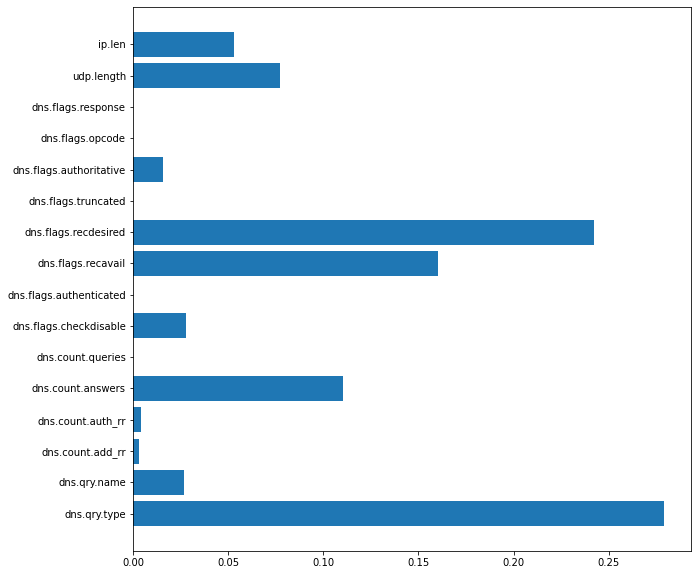

Client 8:
	Feature: ip.len, Score: 0.04590
	Feature: udp.length, Score: 0.06402
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00304
	Feature: dns.flags.truncated, Score: 0.00001
	Feature: dns.flags.recdesired, Score: 0.24982
	Feature: dns.flags.recavail, Score: 0.10856
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00014
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.07982
	Feature: dns.count.auth_rr, Score: 0.15250
	Feature: dns.count.add_rr, Score: 0.01100
	Feature: dns.qry.name, Score: 0.03338
	Feature: dns.qry.type, Score: 0.25181



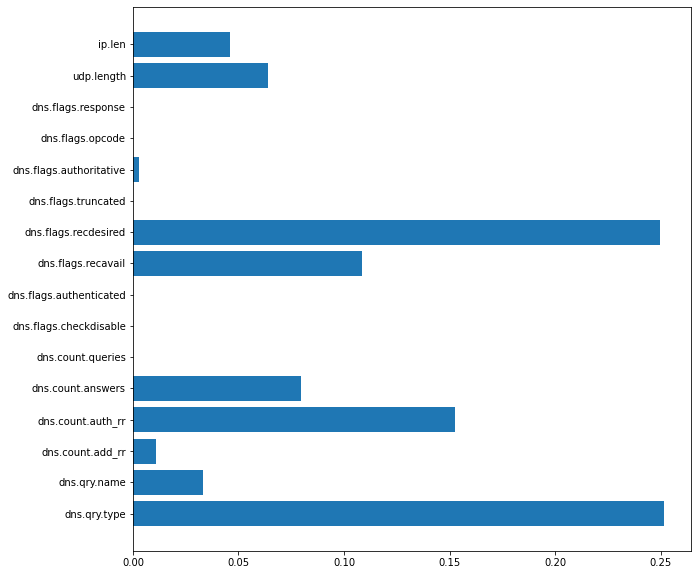

Client 9:
	Feature: ip.len, Score: 0.02191
	Feature: udp.length, Score: 0.03006
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00546
	Feature: dns.flags.truncated, Score: 0.00002
	Feature: dns.flags.recdesired, Score: 0.22649
	Feature: dns.flags.recavail, Score: 0.04752
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.10502
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.05776
	Feature: dns.count.auth_rr, Score: 0.15537
	Feature: dns.count.add_rr, Score: 0.03013
	Feature: dns.qry.name, Score: 0.01251
	Feature: dns.qry.type, Score: 0.30775



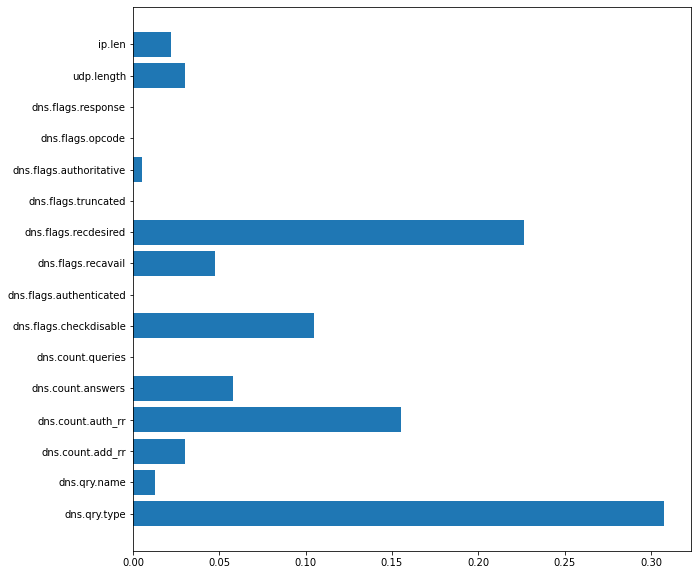

Client 10:
	Feature: ip.len, Score: 0.04681
	Feature: udp.length, Score: 0.04562
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00306
	Feature: dns.flags.truncated, Score: 0.00013
	Feature: dns.flags.recdesired, Score: 0.24110
	Feature: dns.flags.recavail, Score: 0.19014
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00441
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09678
	Feature: dns.count.auth_rr, Score: 0.06189
	Feature: dns.count.add_rr, Score: 0.01758
	Feature: dns.qry.name, Score: 0.01563
	Feature: dns.qry.type, Score: 0.27685



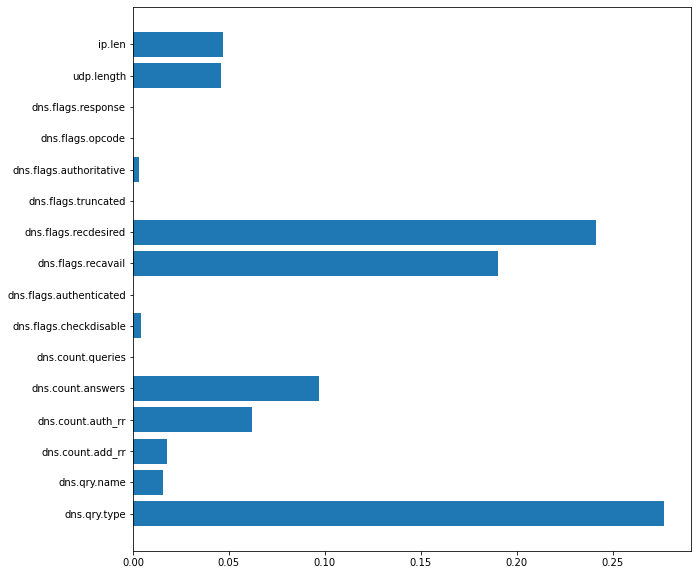

Client 11:
	Feature: ip.len, Score: 0.10393
	Feature: udp.length, Score: 0.13093
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.04405
	Feature: dns.flags.truncated, Score: 0.00049
	Feature: dns.flags.recdesired, Score: 0.24194
	Feature: dns.flags.recavail, Score: 0.16597
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00075
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.15771
	Feature: dns.count.auth_rr, Score: 0.03080
	Feature: dns.count.add_rr, Score: 0.02858
	Feature: dns.qry.name, Score: 0.08562
	Feature: dns.qry.type, Score: 0.00923



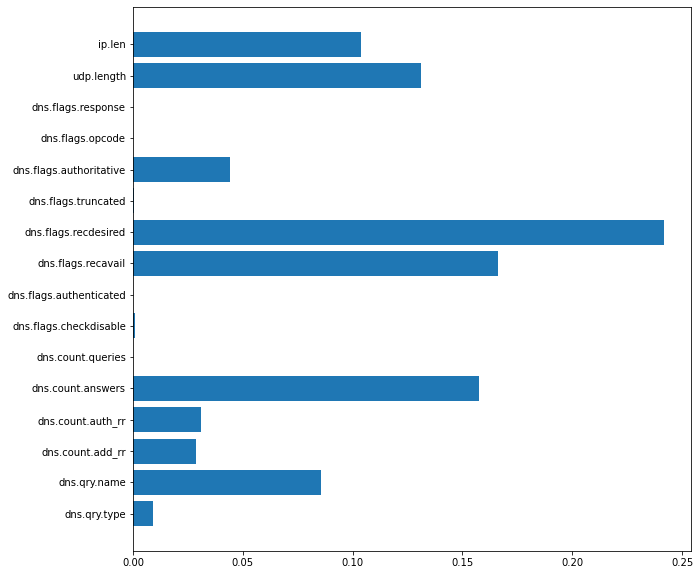

Client 12:
	Feature: ip.len, Score: 0.11973
	Feature: udp.length, Score: 0.10283
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.05139
	Feature: dns.flags.truncated, Score: 0.00017
	Feature: dns.flags.recdesired, Score: 0.28430
	Feature: dns.flags.recavail, Score: 0.16704
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.02824
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.00240
	Feature: dns.count.auth_rr, Score: 0.02121
	Feature: dns.count.add_rr, Score: 0.01019
	Feature: dns.qry.name, Score: 0.19925
	Feature: dns.qry.type, Score: 0.01327



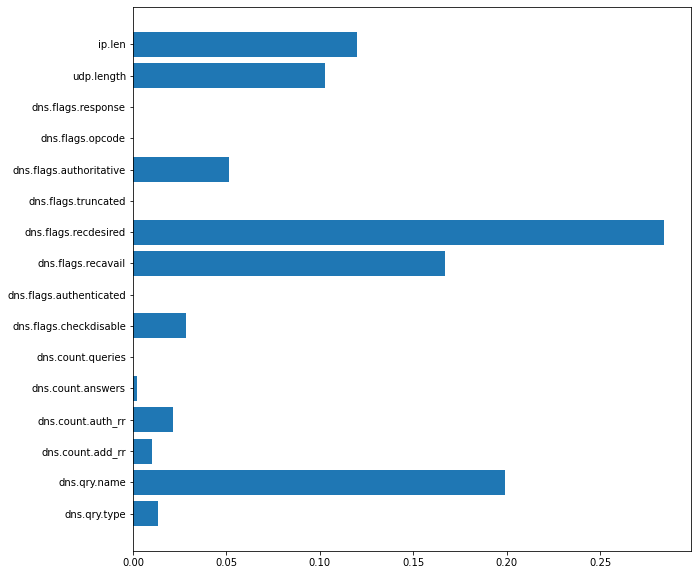

Client 13:
	Feature: ip.len, Score: 0.02937
	Feature: udp.length, Score: 0.04070
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01123
	Feature: dns.flags.truncated, Score: 0.00114
	Feature: dns.flags.recdesired, Score: 0.24663
	Feature: dns.flags.recavail, Score: 0.16148
	Feature: dns.flags.authenticated, Score: 0.00001
	Feature: dns.flags.checkdisable, Score: 0.06140
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.11170
	Feature: dns.count.auth_rr, Score: 0.08648
	Feature: dns.count.add_rr, Score: 0.00262
	Feature: dns.qry.name, Score: 0.00056
	Feature: dns.qry.type, Score: 0.24667



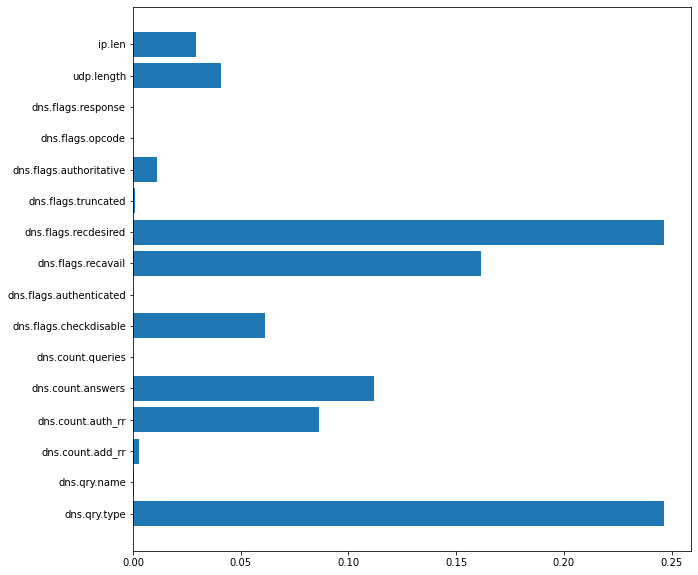

Client 14:
	Feature: ip.len, Score: 0.06396
	Feature: udp.length, Score: 0.07172
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01917
	Feature: dns.flags.truncated, Score: 0.00002
	Feature: dns.flags.recdesired, Score: 0.16668
	Feature: dns.flags.recavail, Score: 0.22570
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00860
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.10375
	Feature: dns.count.auth_rr, Score: 0.00609
	Feature: dns.count.add_rr, Score: 0.00214
	Feature: dns.qry.name, Score: 0.03255
	Feature: dns.qry.type, Score: 0.29961



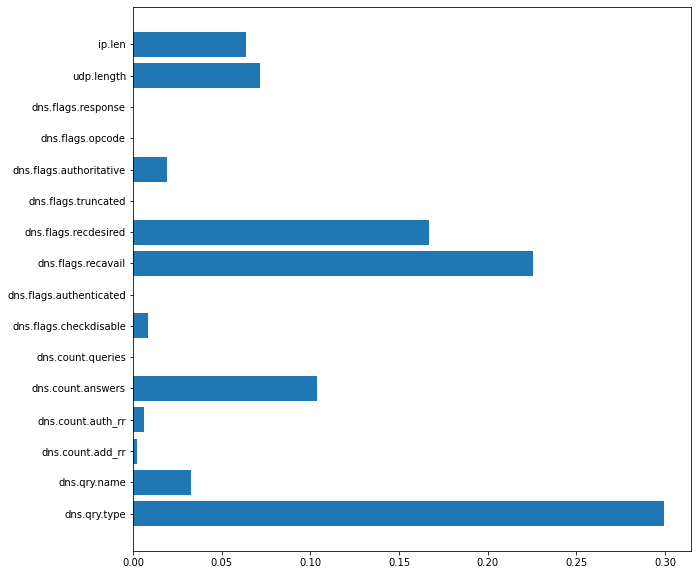

Client 15:
	Feature: ip.len, Score: 0.04112
	Feature: udp.length, Score: 0.05661
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01316
	Feature: dns.flags.truncated, Score: 0.00001
	Feature: dns.flags.recdesired, Score: 0.19311
	Feature: dns.flags.recavail, Score: 0.05613
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00791
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09114
	Feature: dns.count.auth_rr, Score: 0.13677
	Feature: dns.count.add_rr, Score: 0.06577
	Feature: dns.qry.name, Score: 0.01219
	Feature: dns.qry.type, Score: 0.32608



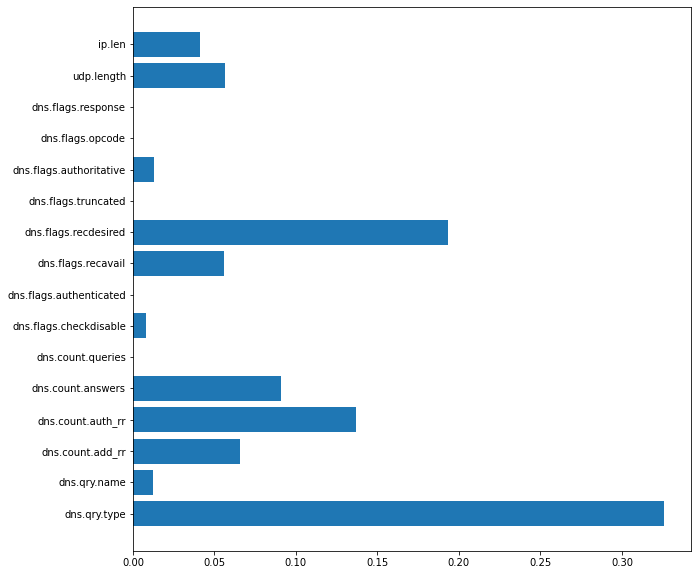

Client 16:
	Feature: ip.len, Score: 0.08265
	Feature: udp.length, Score: 0.09308
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00006
	Feature: dns.flags.authoritative, Score: 0.01038
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.19513
	Feature: dns.flags.recavail, Score: 0.01173
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.02396
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.05105
	Feature: dns.count.auth_rr, Score: 0.14503
	Feature: dns.count.add_rr, Score: 0.02004
	Feature: dns.qry.name, Score: 0.05515
	Feature: dns.qry.type, Score: 0.31173



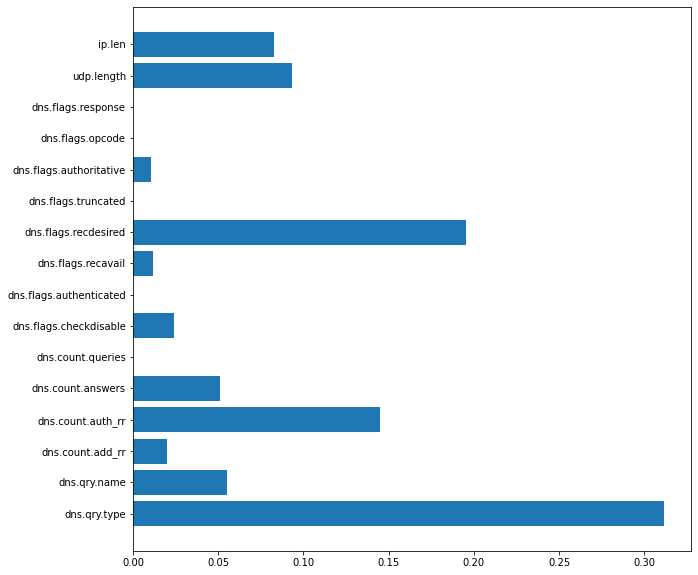

Client 17:
	Feature: ip.len, Score: 0.02359
	Feature: udp.length, Score: 0.02657
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.09524
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.27668
	Feature: dns.flags.recavail, Score: 0.16511
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00001
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.05652
	Feature: dns.count.auth_rr, Score: 0.04388
	Feature: dns.count.add_rr, Score: 0.01244
	Feature: dns.qry.name, Score: 0.01156
	Feature: dns.qry.type, Score: 0.28840



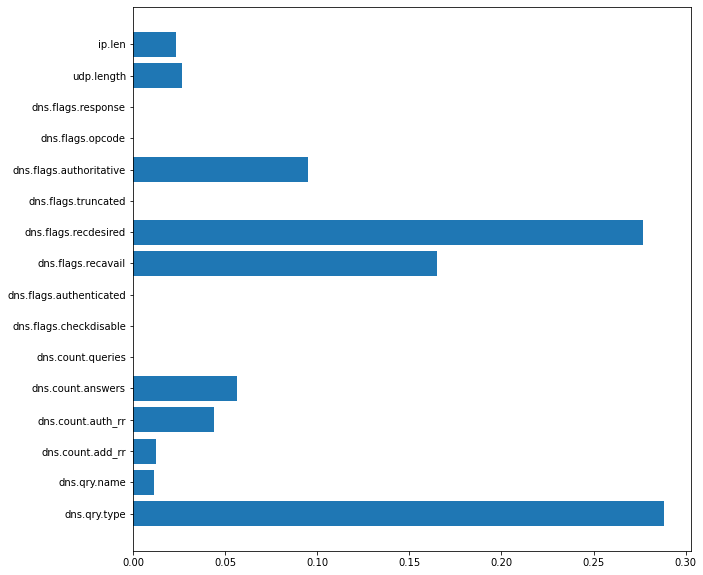

Client 18:
	Feature: ip.len, Score: 0.09165
	Feature: udp.length, Score: 0.12797
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00526
	Feature: dns.flags.truncated, Score: 0.00029
	Feature: dns.flags.recdesired, Score: 0.29612
	Feature: dns.flags.recavail, Score: 0.18131
	Feature: dns.flags.authenticated, Score: 0.00012
	Feature: dns.flags.checkdisable, Score: 0.01416
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.15653
	Feature: dns.count.auth_rr, Score: 0.06123
	Feature: dns.count.add_rr, Score: 0.00217
	Feature: dns.qry.name, Score: 0.02863
	Feature: dns.qry.type, Score: 0.03455



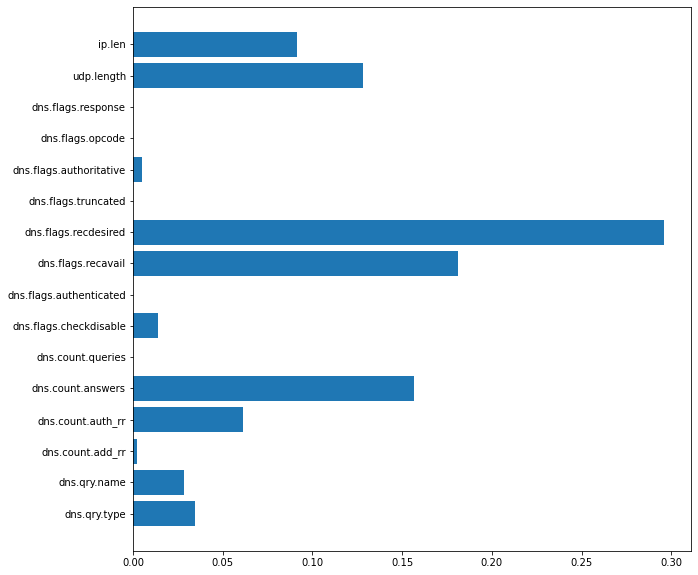

Client 19:
	Feature: ip.len, Score: 0.09869
	Feature: udp.length, Score: 0.09234
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00693
	Feature: dns.flags.truncated, Score: 0.00049
	Feature: dns.flags.recdesired, Score: 0.30136
	Feature: dns.flags.recavail, Score: 0.15346
	Feature: dns.flags.authenticated, Score: 0.00038
	Feature: dns.flags.checkdisable, Score: 0.20402
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.01949
	Feature: dns.count.auth_rr, Score: 0.05574
	Feature: dns.count.add_rr, Score: 0.01014
	Feature: dns.qry.name, Score: 0.04879
	Feature: dns.qry.type, Score: 0.00818



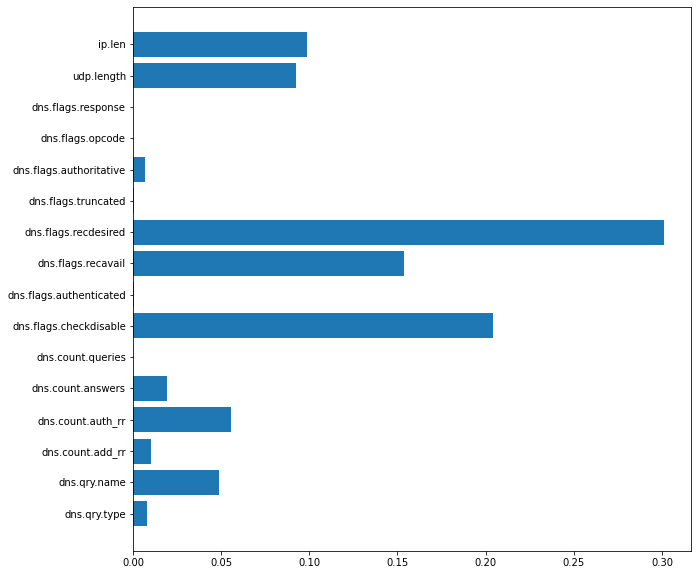

Client 20:
	Feature: ip.len, Score: 0.07579
	Feature: udp.length, Score: 0.10505
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00391
	Feature: dns.flags.truncated, Score: 0.00627
	Feature: dns.flags.recdesired, Score: 0.27505
	Feature: dns.flags.recavail, Score: 0.15616
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00003
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.07240
	Feature: dns.count.auth_rr, Score: 0.00160
	Feature: dns.count.add_rr, Score: 0.00255
	Feature: dns.qry.name, Score: 0.01262
	Feature: dns.qry.type, Score: 0.28856



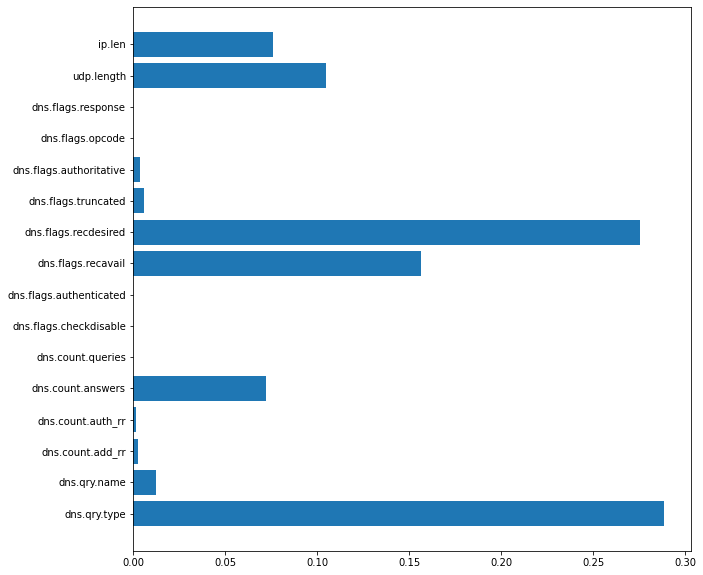

Client 21:
	Feature: ip.len, Score: 0.05298
	Feature: udp.length, Score: 0.07788
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01672
	Feature: dns.flags.truncated, Score: 0.00002
	Feature: dns.flags.recdesired, Score: 0.18111
	Feature: dns.flags.recavail, Score: 0.21553
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00050
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.10358
	Feature: dns.count.auth_rr, Score: 0.00754
	Feature: dns.count.add_rr, Score: 0.00368
	Feature: dns.qry.name, Score: 0.04054
	Feature: dns.qry.type, Score: 0.29992



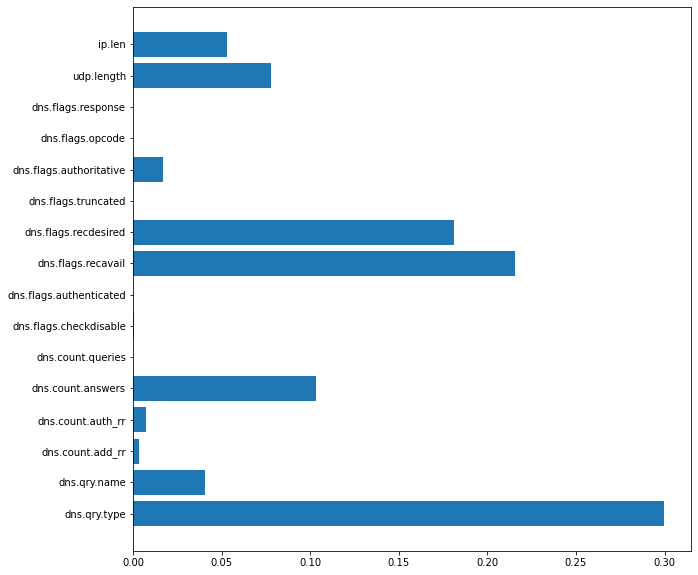

In [ ]:
rfc = RandomForestClassifier()
importance = [[] for i in clients_datasets]
for i in range(21):
    importance[i] = [0 for j in clients_datasets[i].columns[:-1]]
    # run random forest 10 times
    for n in range(10):
        rfc.fit(clients_datasets[i].iloc[:, :-1], clients_datasets[i].iloc[:, -1])
        importance[i] += rfc.feature_importances_

    importance[i] /= 10
    # summarize feature importance
    print('Client ' + str(i+1) + ':')
    for j, v in enumerate(importance[i]):
        print('\tFeature: %s, Score: %.5f' % (clients_datasets[i].columns[j], v))
    print()
    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(clients_datasets[i].columns[:-1], importance[i])
    ax.invert_yaxis()
    plt.show()

Clients drop the features that they found less important. Each client drops features with importance score less than 0.01.

In [ ]:
for i in range(21):
    initial_columns = clients_datasets[i].columns
    for j in range(len(importance[i])):
        if importance[i][j] < 0.01:
            clients_datasets[i].drop(columns=initial_columns[j], inplace=True)
clients_datasets[0].columns

Index(['ip.len', 'udp.length', 'dns.flags.recdesired', 'dns.flags.recavail',
       'dns.count.answers', 'dns.count.auth_rr', 'dns.count.add_rr',
       'dns.qry.name', 'dns.qry.type', 'target'],
      dtype='object')

Before training can start, datasets need to be normalized appropriately. For now, save all the necessary dataframes.

In [ ]:
for i in range(21):
    clients_datasets[i].to_csv('client' + str(i+1) + '.csv', index=False)

general_benign_test.to_csv('general_benign_test.csv', index=False)

for i in range(7):
    booters_tests[i].to_csv('booter_test' + str(i+1) + '.csv', index=False)